# Machine Learning Engineer Nanodegree
## Capstone Project
Simon Jackson
March 21st, 2017

---

In [1]:
# Libraries ---------------------------
import os
import numpy as np
import pandas as pd

from scipy.spatial.distance import cosine
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

from scripts import utility
from scripts import extract_zips
from scripts import data_imdb
from scripts import data_movielens
from scripts.nmf import nmf

# Pretty display for notebooks
%matplotlib inline

# Global utility variables ------------
data_directory = "data"

## Data Importing and preprocessing

Data was downloaded as .zip format...

Extract all data from zip files into the same directory

In [2]:
# Extract all files from zip folders in data directory,
# into data directory
if False:
    extract_zips.extract_all(data_directory)
else:
    print "Extraction turned off. Check that files have been extracted."
    
print "\nFiles in the data directory:\n"
for f in os.listdir(data_directory):
    print "- " + f

Extraction turned off. Check that files have been extracted.

Files in the data directory:

- genome_scores.csv
- genome_tags.csv
- imdb-5000-movie-dataset.zip
- link.csv
- movie.csv
- movielens-20m-dataset.zip
- movie_metadata.csv
- rating.csv
- tag.csv


### IMDB data

In [3]:
imdb = data_imdb.prep(data_directory)
print 'After prep, IMDB data set has {} rows and {} columns'.format(*imdb.shape)

Preparing IMDB data...

- Read in .csv file with 5043 rows and 28 columns
- Dropped unneeded variables
- Extracted IMDB movie ids as `imdb_id` from url in `movie_imdb_link`
- Duplicate movies removed
- Dummy coded `language` to boolean, `english`
- Dummy coded `country` to two boolean vars, `usa`, `uk`
- Dummy coded `color` to boolean.
- Dummy coded `content_ratings` to multiple columns
- Dummy coded `genres` to multiple columns
- Missing values imputed as mean/mode
- Distribution adjustments applied to selected float variables
- All float variables normalized to range between 0 to 1

Prep of IMDB data completed.

After prep, IMDB data set has 4919 rows and 65 columns


In [4]:
# Column types
imdb.dtypes

color                           bool
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
gross                        float64
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
num_user_for_reviews         float64
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
movie_facebook_likes           int64
imdb_id                        int32
english                         bool
usa                             bool
uk                              bool
approved                       int32
g                              int32
gp                             int32
m                              int32
nc-17                          int32
not rated                      int32
p

In [5]:
# Examine few rows
imdb.head(n = 5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,True,0.940956,0.754202,0.000000,0.672316,0.516766,1.000000,Avatar,886204,4834,...,0,0,0,0,1,0,0,0,0,0
1,True,0.595284,0.742109,0.630775,0.687897,0.792616,0.637840,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0
2,True,0.855434,0.711183,0.000000,0.506567,0.696057,0.512914,Spectre,275868,11700,...,0,0,0,0,0,0,0,1,0,0
3,True,1.000000,0.735109,0.995574,1.000000,0.763218,0.767628,The Dark Knight Rises,1144337,106759,...,0,0,0,0,0,0,0,1,0,0
4,False,0.390641,0.635771,0.486175,0.642103,0.365227,0.000000,Star Wars: Episode VII - The Force Awakens ...,8,143,...,0,0,0,0,0,0,0,0,0,0


This information will be used for content-based filtering of movies.

**Plots of categorical/dummy variables**

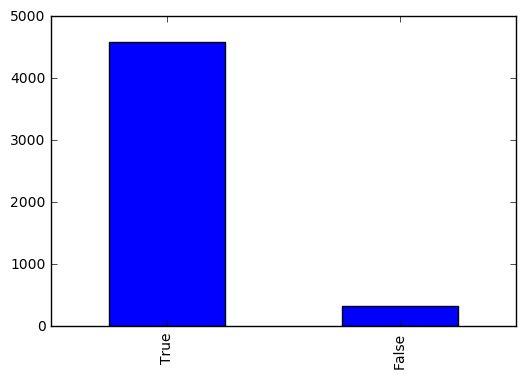

In [6]:
utility.count_plot(imdb.english)

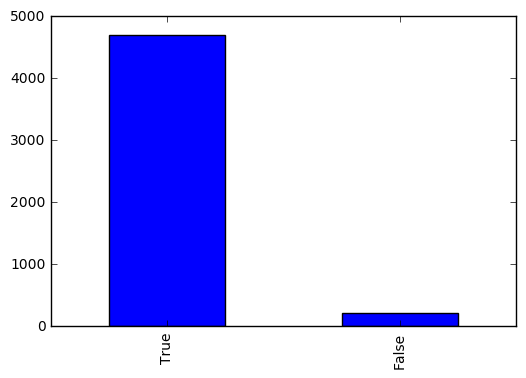

In [7]:
utility.count_plot(imdb['color'])

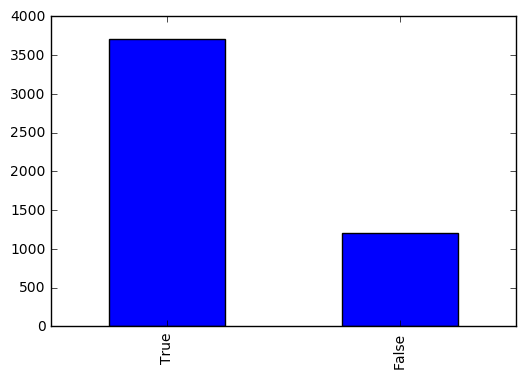

In [8]:
# Visualizing counts for two major countries (USA and UK)
utility.count_plot(imdb.usa)

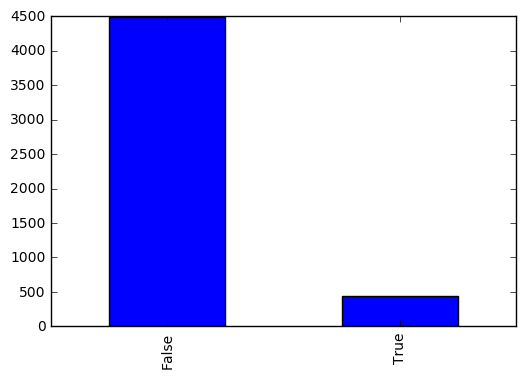

In [9]:
utility.count_plot(imdb.uk)

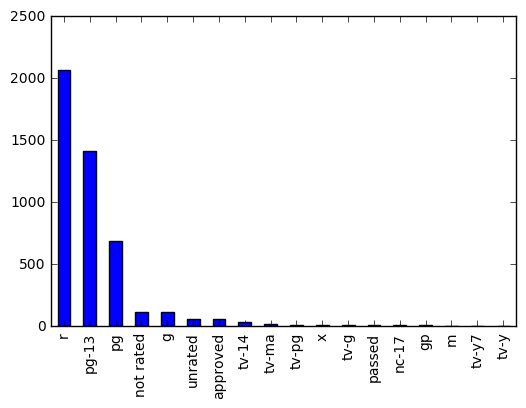

In [10]:
rating_dummies = pd.melt(imdb.ix[:, 'approved':'x'])
utility.count_plot(rating_dummies.variable[rating_dummies.value == 1])

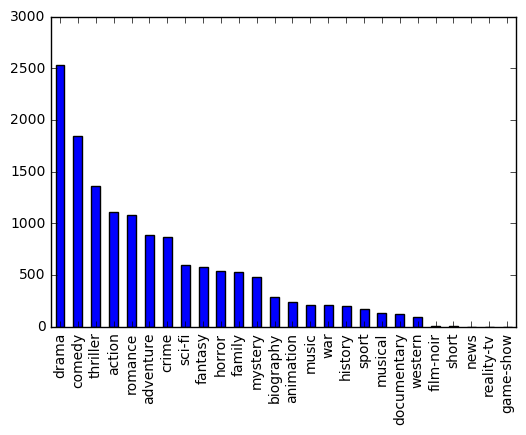

In [11]:
# Visualise counts of genres
genre_dummies = pd.melt(imdb.ix[:, 'action':'western'])
utility.count_plot(genre_dummies.variable[genre_dummies.value == 1])

#### Categorical variables

- `language`: convert to 1 = English, 0 = other
- `genres`: will need to be split into multiple variables indicating whether certain genres were tagged.
- `country`: 1 = USA, 0 = Other (possibly a separate one for UK?)
- `content_rating`: will need a number of categories (R, PG, PG-13, G, etc)

In [12]:
# Plots as examples to run if need to...

#imdb.plot.scatter('num_critic_for_reviews', 'director_facebook_likes')
#utility.float_scatter_matrix(imdb)

In [13]:
imdb.head(3)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,True,0.940956,0.754202,0.000000,0.672316,0.516766,1.000000,Avatar,886204,4834,...,0,0,0,0,1,0,0,0,0,0
1,True,0.595284,0.742109,0.630775,0.687897,0.792616,0.637840,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0
2,True,0.855434,0.711183,0.000000,0.506567,0.696057,0.512914,Spectre,275868,11700,...,0,0,0,0,0,0,0,1,0,0


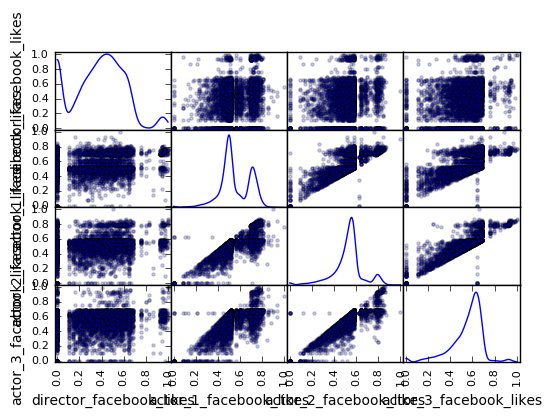

In [14]:
utility.float_scatter_matrix(imdb[['director_facebook_likes',
                                   'actor_1_facebook_likes',
                                   'actor_2_facebook_likes',
                                   'actor_3_facebook_likes']])

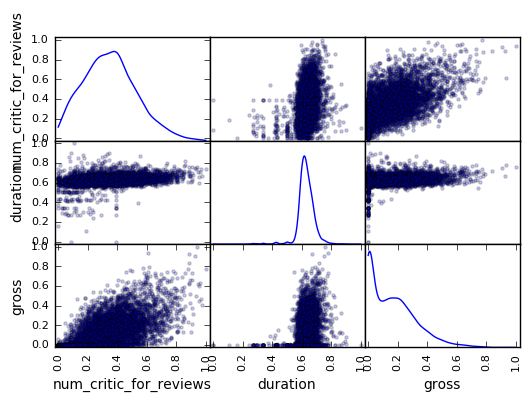

In [15]:
utility.float_scatter_matrix(imdb[['num_critic_for_reviews',
                                   'duration',
                                   'gross',
                                   'num_voted_users',
                                   'cast_total_facebook_likes']])

In [16]:
#from scipy.stats import norm

#np.histogram(norm.pdf(imdb.num_critic_for_reviews))
#np.histogram(norm.ppf((imdb.num_critic_for_reviews.rank() - .5) / len(imdb)))

In [17]:
"""
Return list of most similar to target
- note, for sanity check, should include SAME movie in list
"""
def test_similarity(df, target_i, n_similar = 5):
    
    nrow = df.shape[0]
    similarity = np.array([0.0]*nrow)

    for i in xrange(nrow):
        similarity[i] = 1 - cosine(df.iloc[target_i], df.iloc[i])

    return np.argpartition(similarity, -n_similar)[-n_similar:]

In [18]:
'''
Testing various feature combinations...
'''

n_similar = 5

# Remove title and id
x = imdb.drop(['movie_title', 'imdb_id'], axis=1)

#imdb.movie_title[imdb.movie_title.str.match('Star Wars')]

for target_i in [1, 9, 17, 103, 233]:  # Movies in known series
    print '\nTarget movie ---------------------------- \n'
    print imdb[['movie_title', 'imdb_id']].iloc[target_i]

    print '\nUsing all variables...\n'
    most_similar = test_similarity(x, target_i, n_similar)
    print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

    print '\nUsing genre only...\n'
    most_similar = test_similarity(x.loc[:, 'action':'western'], target_i, n_similar)
    print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

    print '\nUsing genre and content rating...\n'
    most_similar = test_similarity(x.loc[:, 'approved':'western'], target_i, n_similar)
    print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

    print '\nGenre, rating, gross, cast likes...\n'
    most_similar = test_similarity(pd.concat([x.loc[:, 'action':'western'],
                                              x[['gross', 'cast_total_facebook_likes']]],
                                             axis=1, join='inner')
                                   , target_i, n_similar)
    print imdb[['movie_title', 'imdb_id']].iloc[most_similar]

    
#x.sample(10, axis=1))  # Random sampling of columns


Target movie ---------------------------- 

movie_title    Pirates of the Caribbean: At World's End 
imdb_id                                           449088
Name: 1, dtype: object

Using all variables...

                                    movie_title  imdb_id
2436                        Carlos               1321865
378                                   Spy Game    266987
831                                   Superman     78346
1434                            Street Fighter    111301
1     Pirates of the Caribbean: At World's End    449088

Using genre only...

                              movie_title  imdb_id
1468                               Krull     85811
1030  Indiana Jones and the Last Crusade     97576
108                             Warcraft    803096
162                        Gods of Egypt   2404233
622               The Legend of Hercules   1043726

Using genre and content rating...

                                      movie_title  imdb_id
13    Pirates of the Caribbe

In [19]:
# PCA of float variables.
# How do dimensions partition the variance?
_, pca = data_imdb.pca_of_float_vars(imdb)

evar = pca.explained_variance_ratio_ 

print "Total cumulative proportion of variance explained:\n"
for i in xrange(len(evar)):
    print "Dimension {}\t{:04.2f}".format(i + 1, np.sum(evar[:i+1]))

Total cumulative proportion of variance explained:

Dimension 1	0.38
Dimension 2	0.58
Dimension 3	0.72
Dimension 4	0.80
Dimension 5	0.86
Dimension 6	0.90
Dimension 7	0.93
Dimension 8	0.95
Dimension 9	0.97
Dimension 10	0.98
Dimension 11	0.99
Dimension 12	1.00


In [20]:
# 6 dimensions accounts for 90% of the variance!
n_comp = 6
imdb,_ = data_imdb.pca_of_float_vars(imdb, n_comp)

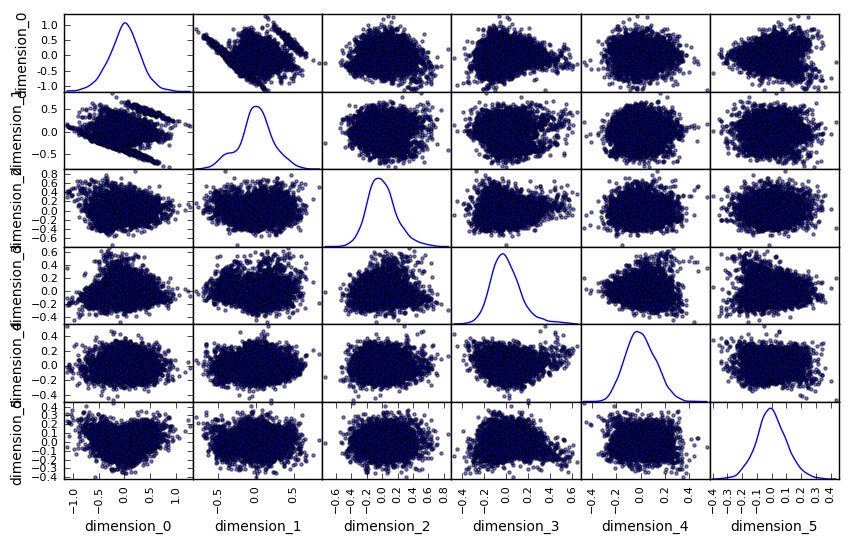

In [21]:
dimension_names = list('dimension_' + str(i) for i in xrange(n_comp))
pd.scatter_matrix(imdb[dimension_names], alpha = 0.5, figsize = (10,6), diagonal = 'kde');

In [22]:
x = imdb.drop(['movie_title', 'imdb_id'], axis=1)

# Include this line to try with just rating, genres and PCA results...
x = pd.concat([x.loc[:, 'approved':'western'], x[dimension_names]], axis = 1, join = 'inner')
 
## NOTE - the use of rating, genre, and PCA results is FAR superior to everything + PCA results in this test

n_similar = 10

for target_i in [9, 17, 185, 202, 1521]:  # Movies in known series
    print '\nMOVIES THAT ARE MOST SIMILAR TO: ' + imdb['movie_title'].iloc[target_i] + ' \n'
    most_similar = test_similarity(x, target_i, n_similar)
    print imdb['movie_title'].iloc[most_similar]
    print '******************************************************** \n'


MOVIES THAT ARE MOST SIMILAR TO: Harry Potter and the Half-Blood Prince  

200               Harry Potter and the Sorcerer's Stone 
64     The Chronicles of Narnia: The Lion, the Witch ...
144                                                 Pan 
38                            Oz the Great and Powerful 
374                      Percy Jackson: Sea of Monsters 
193            Harry Potter and the Prisoner of Azkaban 
282             Harry Potter and the Chamber of Secrets 
9                Harry Potter and the Half-Blood Prince 
33                                  Alice in Wonderland 
106                     Alice Through the Looking Glass 
Name: movie_title, dtype: object
******************************************************** 


MOVIES THAT ARE MOST SIMILAR TO: The Avengers  

52                             Pacific Rim 
112                           Transformers 
53          Transformers: Dark of the Moon 
86     Captain America: The Winter Soldier 
65                       X-Men: Apoc

---

## MovieLens Dataset

In [23]:
lens = data_movielens.prep(data_directory, imdb.imdb_id)
print 'After prep, MovieLens data set has {} rows and {} columns'.format(*lens.shape)

Preparing MovieLens data...

- Read in .csv file with 20000263 rows and 4 columns
- Bind IMDB ID as `imdb_id` using link.csv
- Movies not appearing in IMDB dataset dropped, leaving 13426294 rows and 4 columns
- Drop users who made fewer than 1000 ratings

Prep of MovieLens data completed.

After prep, MovieLens data set has 487691 rows and 4 columns


In [24]:
lens.head(n=5)

,userId,rating,timestamp,imdb_id
0,768,4.0,2003-03-18 15:38:02,113189
1,768,3.0,2003-02-27 20:47:46,112760
2,768,3.0,2003-03-18 15:07:48,112641
3,768,3.0,2003-02-27 19:02:28,113161
4,768,4.0,2003-03-17 01:05:45,112722


There are 385 users who made at least 1000 ratings and at most 2791


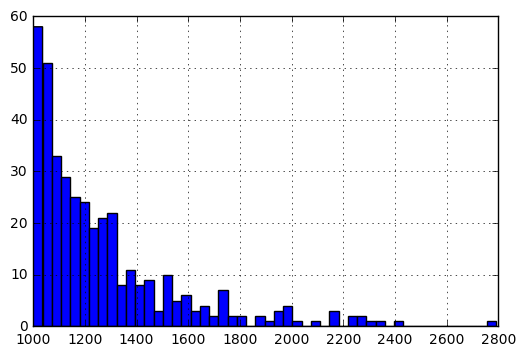

In [25]:
# Number of ratings made by each user
counts = lens.userId.value_counts()
print "There are {} users who made at least {} ratings and at most {}".format(len(counts), counts.min(), counts.max())
counts.hist(bins = 50);

del counts

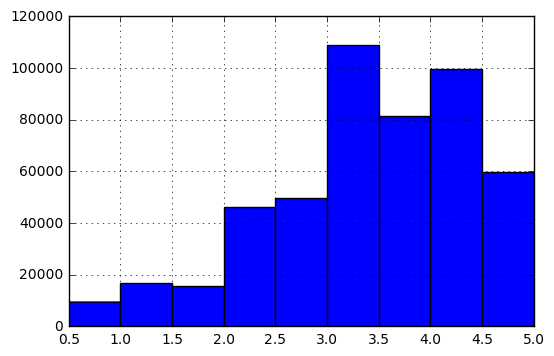

In [26]:
# Rating distribution
lens.rating.hist(bins = 9);

The histogram above reveals that ratings a negatively skewed. Many ratings are high (4.5 - 5), while ratings of low values are very infrequent. This relates to a known problem that rating data is not missing at random<sup>1</sup>. Users tend to rate items that like rather than items they do not like.

One thing to consider is whether this unbalanced data will cause problems.



<sup>1</sup>Marlin, Benjamin M., and Richard S. Zemel. "Collaborative prediction and ranking with non-random missing data." In Proceedings of the third ACM conference on Recommender systems, pp. 5-12. ACM, 2009.

---

# Data


The data we're interested in learning from are the user ratings of movies. This can be contained as matrix with each user being a row, and each movie being a colum.

In [27]:
# Convert ratings to wide format
R = lens[['userId', 'imdb_id', 'rating']].pivot(columns='imdb_id', values='rating', index='userId')

# Extract records of relevant row and column IDs
R_imdb_id = R.columns.tolist()  # matching imdb_id for each column
R_userId  = R.index.tolist()    # matching userId for each row

# Convert to 2D numpy array
R = R.as_matrix()

print 'Data stored as a sparse matrix with {} rows (users) and {} columns (movies):\n'.format(R.shape[0], R.shape[1])
R

Data stored as a sparse matrix with 385 rows (users) and 4165 columns (movies):



array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  4. , ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  2.5, ...,  nan,  nan,  nan],
       [ nan,  nan,  4. , ...,  nan,  nan,  nan],
       [ nan,  nan,  3. , ...,  nan,  nan,  nan]])

---

# Baseline Model

This section will setup a baseline model against which performance should be compared.

The baseline model will estimate the rating of a movie for a user as the mean of the ratings that user has already given.

This would be unlikley to perform well in real life. However, because the validation procedure here will be on already rated movies, and the ratings are biased, this model will perform reasonably well. As this bias applies to all the models that will be tested, this baseline is therefore a good comparison.

In [28]:
predicted = np.empty(R.shape)
ncols = R.shape[1]

''' Compute value of each cell as mean of all other cells in repsective row'''
for i in xrange(ncols):
    others = np.delete(R, i, 1)
    predicted[:, i] = np.nanmean(others, axis = 1)
    if i % 500 == 0:
        print 'Predictions made for {} movies out of {}'.format(i, ncols)
    if i == ncols - 1:
        print 'All movie predictions made.'

del ncols

Predictions made for 0 movies out of 4165
Predictions made for 500 movies out of 4165
Predictions made for 1000 movies out of 4165
Predictions made for 1500 movies out of 4165
Predictions made for 2000 movies out of 4165
Predictions made for 2500 movies out of 4165
Predictions made for 3000 movies out of 4165
Predictions made for 3500 movies out of 4165
Predictions made for 4000 movies out of 4165
All movie predictions made.


In [29]:
baseline_rmse = utility.rmse(R[~np.isnan(R)], predicted[~np.isnan(R)])
print 'Baseline RMSE: {:.4}'.format(baseline_rmse)

Baseline RMSE: 0.9396


---

## Content-based filtering 

This section will examine the performance of a content-based filtering approach.

This approach computes the mean of the `k`-most similar movies that have been rated by the user.

Similarity is determined using the IMDB data set, as described above.

In [30]:
# This requires the similarity of each movie to each other based on the IMDB data set
# We'll use the features determined in earlier steps:
# - rating, genres and PCA results...

# Data for movies kept in matrix
imdb_kept = imdb[imdb.imdb_id.isin(R_imdb_id)]

# Ordered in same way as ratings matrix
imdb_kept = imdb_kept.set_index(['imdb_id'])
imdb_kept = imdb_kept.sort_index()

if np.all(R_imdb_id == imdb_kept.index):
    # Similarity between relevant movies
    imdb_sims = pd.concat([imdb_kept.loc[:, 'approved':'western'], imdb_kept[dimension_names]], axis = 1, join = 'inner')
    imdb_sims = np.array(cosine_similarity(imdb_sims))
    print 'Similarities computed as 2D array with shape: {}'.format(imdb_sims.shape)
else:
    print 'Movie IDs do not match between ratings matrix and imdb data'

del imdb_kept

Similarities computed as 2D array with shape: (4165L, 4165L)


In [31]:
k = 20  # Computing mean rating from k most similar movies

predicted = np.empty(R.shape)
nrows = R.shape[0]
ncols = R.shape[1]

''' Compute value of each cell as mean of all other cells in repsective row'''
for movie in xrange(ncols):
    others = np.delete(R, movie, 1)
    sims   = np.delete(imdb_sims[movie], movie, 0)
    
    for user in xrange(nrows):
        ratings = others[user]
        # non-nan values
        nnRatings = ratings[~np.isnan(ratings)]
        nnSims    = sims[~np.isnan(ratings)]
        #predicted[user, movie] = np.sum(nnRatings * nnSims) / np.sum(nnSims)  # Weighted mean of all!
        topK      = nnSims.argsort()[-k:][::-1]
        predicted[user, movie] = np.mean(nnRatings[topK])
    
    if movie % 500 == 0:
        print 'Predictions made for {} movies out of {}'.format(movie, ncols)
    if movie == ncols - 1:
        print 'All movie predictions made.'

del ncols, nrows, k

Predictions made for 0 movies out of 4165
Predictions made for 500 movies out of 4165
Predictions made for 1000 movies out of 4165
Predictions made for 1500 movies out of 4165
Predictions made for 2000 movies out of 4165
Predictions made for 2500 movies out of 4165
Predictions made for 3000 movies out of 4165
Predictions made for 3500 movies out of 4165
Predictions made for 4000 movies out of 4165
All movie predictions made.


In [ ]:
content_rmse = utility.rmse(R[~np.isnan(R)], predicted[~np.isnan(R)])
print 'Baseline RMSE: {:.4}'.format(content_rmse)

Baseline RMSE: 0.8717


This is a good improvement on the baseline method. To possibly improve on this, we'll compare results for different values of `k`... 

In [ ]:
kValues = [10, 20, 30, 40, 50]  # Various values of k to search

nrows = R.shape[0]
ncols = R.shape[1]
results = []

for k in kValues:
    
    print 'Making predictions using {}-most similar movies...\t'.format(k),
    
    predicted = np.empty(R.shape)
    
    for movie in xrange(ncols):
        others = np.delete(R, movie, 1)
        sims   = np.delete(imdb_sims[movie], movie, 0)

        for user in xrange(nrows):
            ratings = others[user] 
            nnRatings = ratings[~np.isnan(ratings)]
            nnSims    = sims[~np.isnan(ratings)]
            topK      = nnSims.argsort()[-k:][::-1]
            predicted[user, movie] = np.mean(nnRatings[topK])
    
    rmse = utility.rmse(R[~np.isnan(R)], predicted[~np.isnan(R)])
    results.append(rmse)
    print 'Completed with RMSE of {:.4}'.format(rmse)
    
del ncols, nrows, k

Making predictions using 10-most similar movies...	

It appears that `k = 30` worked best for minimising rating errors. Making predictions based on too few movies (`k = 10`) likley did not provide enough information for ratings to generalise well. Predictions based on too many movies (`k = 50`) likley lost sufficient specificity to make a good prediction.

---

## Collaborative filtering

Content-based filtering has proven to improve rating predictions over baseline models. However, collaborative filtering is often cited as a more effective method for implementing recommender systems.

The challenge in this case is that collaborative filtering methods alone cannot be used. This is because "new" movies have not been rated by users and, therefore, prohibit the sole use of collaborative methods.

Instead, collaborative methods can be used in combination with the content-based methods above in a hybrid recommender system. Specifically, collaborative filtering can be used to estimate a user's ratings for all movies, and then the content method above can be used in with the filled in results.

The code below implements non-negative matrix factorisation via stochastic gradient descent, which has proven to be a robust and scalable method for collaborative filtering with sparse data.

It requires the tuning of one primary hyperparamter: the nuumber of latent features.

In [ ]:
print 'Raw data sparsity: {:.4}'.format(np.mean(np.isnan(R)))

# NMF operates on the entire matrix. Therefore, to evaluate performance, we must "mask" a proportion of the existing ratings.
p_mask = 0.3
mask = np.random.binomial(1, p_mask, size=R.shape).astype(np.bool)
T = np.copy(R)
T[mask] = np.nan
print 'Training data sparsity: {:.4}'.format(np.mean(np.isnan(T)))

# Convert to scipy sparse matrix and learn
T[np.isnan(T)] = 0
SparseT = csr_matrix(T)
n_latents = 10
nP, nQ = nmf(SparseT, n_latents, max_iter=1000, print_step=100)

In [ ]:
# Evaluating performance
test_indices = np.array(~np.isnan(R)) & np.array(T == 0)
true = R[test_indices]
predicted = np.dot(nP, nQ)[test_indices]

print 'RMSE of collaborative filtering given entire matrix: {:.4}'.format(utility.rmse(true, predicted))

This is a good result. However, it's a single estimate, which could be better informed by cross validation. Furthermore, there is scope to tune the hyperparameter definine ght enumber of latent variables. The following section will implement k-fold cross-validation for multiple values of the `n_latents` hyperparameter.

In [ ]:
k_folds = 5
n_latent_vals = [10, 40, 70, 100]

np.random.seed(123)  # For replicability
folds = np.random.randint(0, k_folds, size=R.shape)

results = []

for n_latents in n_latent_vals:
    
    print '\nTraining with {} latent dimensions --------------------\n'.format(n_latents)
    nResults = []
    for fold in xrange(k_folds):

        print '\t-- Training for fold {} --'.format(fold + 1)

        mask = folds == fold
        T = np.copy(R)
        T[mask] = np.nan
        T[np.isnan(T)] = 0
        SparseT = csr_matrix(T)
        nP, nQ = nmf(SparseT, n_latents, max_iter=1000, print_step=1000)

        test_indices = np.array(~np.isnan(R)) & np.array(T == 0)
        true = R[test_indices]
        predicted = np.dot(nP, nQ)[test_indices]

        rmse = utility.rmse(true, predicted)
        nResults.append(rmse)
    
    results.append(np.mean(nResults))
    print '******************************************************** \n'

In [ ]:
for i, n in enumerate(n_latent_vals):
    print 'RMSE for {} latent dimensions:\t{:.4}'.format(n, results[i])

It appears that fewer (10) latent dimensions performs best. We can retry searching with a smaller number of dimensions:

In [ ]:
k_folds = 5
n_latent_vals = [2, 4, 6, 8]

np.random.seed(123)  # For replicability
folds = np.random.randint(0, k_folds, size=R.shape)

results = []

for n_latents in n_latent_vals:
    
    print '\nTraining with {} latent dimensions --------------------\n'.format(n_latents)
    nResults = []
    for fold in xrange(k_folds):

        print '\t-- Training for fold {} --'.format(fold + 1)

        mask = folds == fold
        T = np.copy(R)
        T[mask] = np.nan
        T[np.isnan(T)] = 0
        SparseT = csr_matrix(T)
        nP, nQ = nmf(SparseT, n_latents, max_iter=1000, print_step=100)

        test_indices = np.array(~np.isnan(R)) & np.array(T == 0)
        true = R[test_indices]
        predicted = np.dot(nP, nQ)[test_indices]

        rmse = utility.rmse(true, predicted)
        nResults.append(rmse)
    
    results.append(np.mean(nResults))
    print '******************************************************** \n'

In [ ]:
for i, n in enumerate(n_latent_vals):
    print 'RMSE for {} latent dimensions:\t{:.4}'.format(n, results[i])

There is not much variance in these estimates (and variance is probably due to chance/sampling). From these results, 4 latent dimensions is the most suitable option.

---

## Hybrid recommender system

Recommendations can now be made on the basis of a hybrid recommender system that does the following:

- Uses NMF collaborative filtering to estimate all missing ratings
- Uses k-nearest neighbours as content-based method to estimate rating for new movies

So far, performance of the baseline and content-based recommender systems has used leave-one-out validation.

*However, incorporating NMF into this system is unfeasible on a single machine like the laptop being used to run these analyses. Instead, bootstrapped sampling will be used...*

In [ ]:
# Hyperparameters deteremined via cross-validation
n_latents = 4

# Randomly sample a proportion of movies to test with...
p_movies = 0.2

n_test = int(len(R_imdb_id) * p_movies)
np.random.seed(11)
test_i = np.random.choice(len(R_imdb_id), n_test)

train = np.nan_to_num(np.delete(R, test_i, 1))
test  = R[:, test_i]

# Fill in missing ratings in training data
nP, nQ = nmf(csr_matrix(train), n_latents, max_iter=1000, print_step=200)
estimates = np.dot(nP, nQ)
train[train == 0] = estimates[train == 0]

del p_movies, n_test, nP, nQ

In [ ]:
# For each movie in the test set, find the k most similar movies, then use those ratings to make predictions...
#np.delete(imdb_sims[test_i], test_i, 1).shape  # Each row is a test movie, each col is a train movie
k = 30
predicted = np.empty(test.shape)

for i,movie in enumerate(test_i):
    sims = imdb_sims[movie, -test_i]
    topK = sims.argsort()[-k:][::-1]
    simRatings = train[:, topK]
    predicted[:, i] = np.nanmean(simRatings, axis = 1)

print 'Predictions completed.'

In [ ]:
hybrid_rmse = utility.rmse(test[~np.isnan(test)], predicted[~np.isnan(test)])
print 'Hybrid RMSE: {:.4}'.format(hybrid_rmse)